In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
from Optimizer import RMSProp
import matplotlib.pyplot as plt
tf.compat.v1.enable_eager_execution()

# Quadratic function

Here we minimize $f(x, y) = 100 x^2 + 2 y^2$

In [22]:
repeat_n_times = 20
learning_rates = [1, 0.1, 0.01, 0.001]
seeds = [i for i in range(1000, 1000 + repeat_n_times)]
results = []
for learning_rate in learning_rates:
    print(f"Evaluating learning_rate = {learning_rate}")
    for seed in tqdm(seeds):
        rng = np.random.default_rng(seed=seed)
        minimizers = {
            "RMSProp": RMSProp.RMSProp(learning_rate=learning_rate),
            "SGD": tf.keras.optimizers.SGD(learning_rate),
            "ADAM": tf.keras.optimizers.Adam(learning_rate)
        }
        x_0 = rng.uniform(-5, 5)
        y_0 = rng.uniform(-5, 5)
        for minimizer_name, minimizer in minimizers.items():
            x = tf.Variable(x_0)
            y = tf.Variable(y_0)
            target_fn = lambda: 100 * x * x + 2 * y * y
            n_iter = 0
            did_converge = True
            while abs(target_fn() - 0) >= 0.01:
                n = minimizer.minimize(target_fn, var_list=[x, y])
                if np.isnan(x.numpy()) or np.isnan(y.numpy()):
                    did_converge = False
                    break
                n_iter += 1
                if n_iter > 10_000:
                    did_converge = False
                    break
            distance = np.sqrt(x.numpy() * x.numpy() + y.numpy() * y.numpy())
            results += [{
                "x_0": x_0,
                "y_0": y_0,
                "seed": seed,
                "learning_rate": learning_rate,
                "minimizer": minimizer_name,
                "n_iter": n_iter,
                "did_converge": did_converge,
                "distance": distance
            }]

results = pd.DataFrame(results)

Evaluating learning_rate = 1


100%|██████████| 20/20 [02:54<00:00,  8.70s/it]


Evaluating learning_rate = 0.1


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


Evaluating learning_rate = 0.01


100%|██████████| 20/20 [08:31<00:00, 25.59s/it]


Evaluating learning_rate = 0.001


100%|██████████| 20/20 [08:38<00:00, 25.94s/it]


In [23]:
results

,x_0,y_0,seed,learning_rate,minimizer,n_iter,did_converge,distance
0,0.213857,1.038418,1000,1.000,RMSProp,5,True,0.052538
1,0.213857,1.038418,1000,1.000,SGD,18,False,NaN
2,0.213857,1.038418,1000,1.000,ADAM,41,True,0.064424
3,1.125949,-4.842995,1001,1.000,RMSProp,10001,False,0.707106
4,1.125949,-4.842995,1001,1.000,SGD,17,False,NaN
...,...,...,...,...,...,...,...,...
235,0.939754,-0.450409,1018,0.001,SGD,462,True,0.070700
236,0.939754,-0.450409,1018,0.001,ADAM,2070,True,0.009967
237,-2.830731,-1.040050,1019,0.001,RMSProp,2860,True,0.009912
238,-2.830731,-1.040050,1019,0.001,SGD,671,True,0.070643


In [24]:
results.to_csv("quadratic_function_results.csv")

In [25]:
results.groupby(["minimizer", "learning_rate"]).agg("mean")[["n_iter","did_converge"]]

n_iter  did_converge
minimizer learning_rate                        
ADAM      0.001           5338.50           1.0
          0.010            754.10           1.0
          0.100             69.35           1.0
          1.000             53.90           1.0
RMSProp   0.001           2980.50           1.0
          0.010            322.80           1.0
          0.100             42.70           1.0
          1.000           3003.65           0.7
SGD       0.001            776.60           1.0
          0.010          10001.00           0.0
          0.100             29.45           0.0
          1.000             17.05           0.0

<AxesSubplot:xlabel='learning_rate', ylabel='n_iter'>

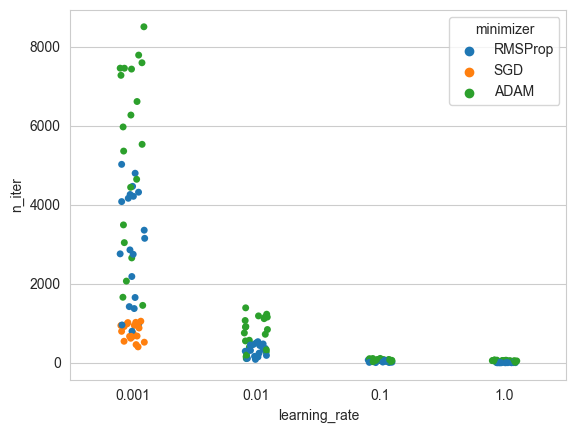

In [27]:
sns.stripplot(results.loc[results.did_converge], x="learning_rate", hue="minimizer", y="n_iter")

## Visualization

In [ ]:
learning_rate = 0.001
minimizers = {
    "RMSProp": RMSProp.RMSProp(learning_rate=learning_rate),
    "SGD": tf.keras.optimizers.SGD(learning_rate),
    "ADAM": tf.keras.optimizers.Adam(learning_rate)
}
x_n = []
for minimizer_name, minimizer in minimizers.items():
    x = tf.Variable(2.0)
    y = tf.Variable(5.0)
    target_fn = lambda: 100 * x * x + 2 * y * y
    n_iter = 0
    while abs(target_fn() - 0) >= 0.1:
        n = minimizer.minimize(target_fn, var_list=[x, y])
        n_iter += 1
        x_n += [{
            'x': x.numpy(),
            'y': y.numpy(),
            'minimizer': minimizer_name
        }]
        if n_iter > 2000:
            break


x_n = pd.DataFrame(x_n)

In [3]:
xlist = np.linspace(-6.0, 6.0, 100)
ylist = np.linspace(-6.0, 6.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = 100 * X * X + 2 * Y * Y

<AxesSubplot:xlabel='x', ylabel='y'>

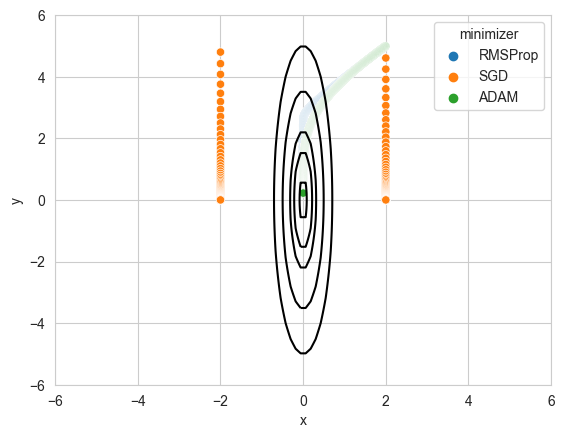

In [4]:
fig, ax = plt.subplots()
ax.contour(X, Y, Z, levels=[0, 0.1, 1, 5, 10, 25, 50], colors="black")
sns.scatterplot(x_n, x="x", y="y", hue="minimizer")

# Mixture of steep and flat function

$f(x, y) = \begin{cases}
x^2 + y^2 - 9, x\in(-\infty, -3.01) \cup (3, \infty) \\
-0.01x + y^2 + 0.03, x\in[-3.01, 3]
\end{cases}$

In [29]:
repeat_n_times = 20
learning_rates = [0.1, 0.01, 0.001]
seeds = [i for i in range(1000, 1000 + repeat_n_times)]
results = []

def target_fn():
    if x < -3.01:
        return x * x - 9 + y * y
    elif x < 3:
        return -0.01 * x + 0.03 + y * y
    else:
        return x * x - 9 + y * y

for learning_rate in learning_rates:
    print(f"Evaluating learning_rate = {learning_rate}")
    for seed in tqdm(seeds):
        rng = np.random.default_rng(seed=seed)
        minimizers = {
            "RMSProp": RMSProp.RMSProp(learning_rate=learning_rate),
            "SGD": tf.keras.optimizers.SGD(learning_rate),
            "ADAM": tf.keras.optimizers.Adam(learning_rate)
        }
        x_0 = rng.uniform(-5, -3.5)
        y_0 = rng.uniform(-5, 5)
        for minimizer_name, minimizer in minimizers.items():
            x = tf.Variable(x_0)
            y = tf.Variable(y_0)
            n_iter = 0
            did_converge = True
            while abs(target_fn() - 0) >= 0.001:
                n = minimizer.minimize(target_fn, var_list=[x, y])
                if np.isnan(x.numpy()) or np.isnan(y.numpy()):
                    did_converge = False
                    break
                n_iter += 1
                if n_iter > 10_000:
                    did_converge = False
                    break

            results += [{
                "x_0": x_0,
                "y_0": y_0,
                "seed": seed,
                "learning_rate": learning_rate,
                "minimizer": minimizer_name,
                "n_iter": n_iter,
                "did_converge": did_converge
            }]

results = pd.DataFrame(results)

Evaluating learning_rate = 0.1


100%|██████████| 20/20 [15:26<00:00, 46.30s/it]


Evaluating learning_rate = 0.01


100%|██████████| 20/20 [15:48<00:00, 47.42s/it]


Evaluating learning_rate = 0.001


100%|██████████| 20/20 [23:00<00:00, 69.01s/it]


In [30]:
results

,x_0,y_0,seed,learning_rate,minimizer,n_iter,did_converge
0,-4.217921,1.038418,1000,0.100,RMSProp,10001,False
1,-4.217921,1.038418,1000,0.100,SGD,5602,True
2,-4.217921,1.038418,1000,0.100,ADAM,2484,True
3,-4.081108,-4.842995,1001,0.100,RMSProp,10001,False
4,-4.081108,-4.842995,1001,0.100,SGD,5514,True
...,...,...,...,...,...,...,...
175,-4.109037,-0.450409,1018,0.001,SGD,10001,False
176,-4.109037,-0.450409,1018,0.001,ADAM,10001,False
177,-4.674610,-1.040050,1019,0.001,RMSProp,7678,True
178,-4.674610,-1.040050,1019,0.001,SGD,10001,False


In [31]:
results.to_csv("flat_function_results.csv")

In [32]:
results.groupby(["minimizer", "learning_rate"]).agg("mean")[["n_iter","did_converge"]]

n_iter  did_converge
minimizer learning_rate                        
ADAM      0.001          10001.00           0.0
          0.010           9049.65           1.0
          0.100           2651.60           1.0
RMSProp   0.001           7504.60           1.0
          0.010            843.50           1.0
          0.100          10001.00           0.0
SGD       0.001          10001.00           0.0
          0.010          10001.00           0.0
          0.100           5594.90           1.0

<AxesSubplot:xlabel='learning_rate', ylabel='n_iter'>

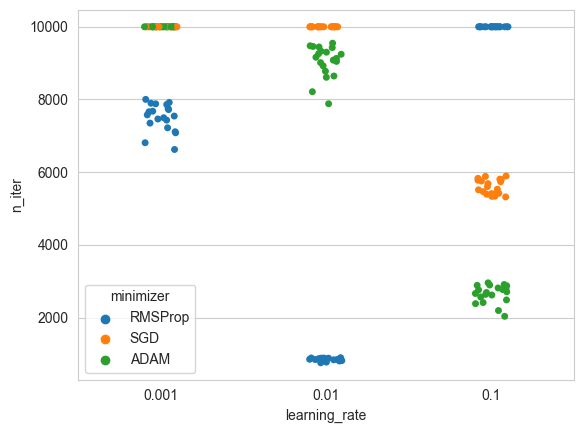

In [33]:
sns.stripplot(results, x="learning_rate", hue="minimizer", y="n_iter")

## Visualizations

In [140]:
def function(x: np.array, y):
    x_func = np.vectorize(lambda x: x*x - 9 if x < -3.01 or x > 3 else -0.01 * x + 0.03)
    x_part = x_func(x)
    return x_part + y * y


xlist = np.linspace(-6.0, 6.0, 100)
ylist = np.linspace(-6.0, 6.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = function(X, Y)


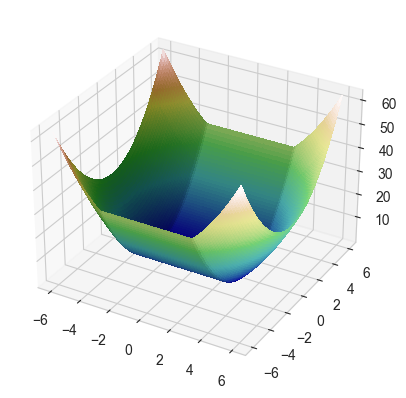

In [141]:
from matplotlib import cm
from matplotlib.colors import LightSource

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
rgb = ls.shade(Z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

In [153]:
def target_fn():
    if x < -3.01:
        return x * x - 9 + y * y
    elif x < 3:
        return -0.01 * x + 0.03 + y * y
    else:
        return x * x - 9 + y * y

learning_rate = 0.1
minimizers = {
    "RMSProp": RMSProp.RMSProp(learning_rate=learning_rate),
    "SGD": tf.keras.optimizers.SGD(learning_rate),
    "ADAM": tf.keras.optimizers.Adam(learning_rate)
}


x_n = []
for minimizer_name, minimizer in minimizers.items():
    x = tf.Variable(-5.0)
    y = tf.Variable(5.0)
    n_iter = 0
    while abs(target_fn() - 0) >= 0.001:
        n = minimizer.minimize(target_fn, var_list=[x, y])
        n_iter += 1
        x_n += [{
            'x': x.numpy(),
            'y': y.numpy(),
            'n': n_iter,
            'minimizer': minimizer_name
        }]
        if n_iter > 10_000:
            break

In [154]:
x_n = pd.DataFrame(x_n)
x_n.tail(1)

,x,y,n,minimizer
18419,2.901587,2.802597e-45,2955,ADAM


<AxesSubplot:xlabel='x', ylabel='y'>

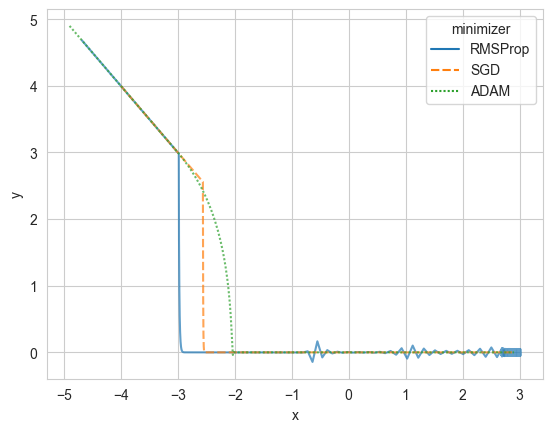

In [190]:
fig, ax = plt.subplots()
# ax.contour(X, Y, Z, levels=[0, 0.05, 0.1, 1, 5, 10, 25, 50], colors="black", alpha=0.2)
sns.lineplot(x_n, x="x", y="y", hue="minimizer", alpha=0.7, style='minimizer', ax=ax)

In [5]:
 with tf.GradientTape() as g:
    g.watch(x)
    g.watch(y)
    t= target_fn()
    gradients = g.gradient(t, sources=[x, y])
    print(gradients) # 12, 20

[<tf.Tensor: id=177489, shape=(), dtype=float32, numpy=0.00028734957>, <tf.Tensor: id=177490, shape=(), dtype=float32, numpy=0.89035296>]
